In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from plot_style import *
from tabulate import tabulate

from datetime import datetime as DT

In [2]:
sync_df = pd.read_feather("out/sync-v2.feather")
async_df = pd.read_feather("out/async.feather")
async_df.head()

,train/acc,train/loss,train/epoch,train/batch_idx,train/time,training_start,training_end,node/idx,node/kind,parent/idx,parent/kind,round,train/rel_time,strategy,mode,workers
0,0.31250,2.297922,0,0,2024-04-01 23:27:13.027266,2024-04-01 23:27:12.914983,2024-04-01 23:27:41.179950,2,worker,0,leader,0,4.762195,FedAsync,async,12
1,0.15625,2.321715,0,1,2024-04-01 23:27:13.070513,2024-04-01 23:27:12.914983,2024-04-01 23:27:41.179950,2,worker,0,leader,0,4.805442,FedAsync,async,12
2,0.21875,2.317055,0,2,2024-04-01 23:27:13.125010,2024-04-01 23:27:12.914983,2024-04-01 23:27:41.179950,2,worker,0,leader,0,4.859939,FedAsync,async,12
3,0.09375,2.333768,0,3,2024-04-01 23:27:13.177854,2024-04-01 23:27:12.914983,2024-04-01 23:27:41.179950,2,worker,0,leader,0,4.912783,FedAsync,async,12
4,0.28125,2.301785,0,4,2024-04-01 23:27:13.268923,2024-04-01 23:27:12.914983,2024-04-01 23:27:41.179950,2,worker,0,leader,0,5.003852,FedAsync,async,12


In [16]:
def get_workers_rounds(df: pd.DataFrame) -> tuple[list, list]:
    df_workers = async_df.query("`node/kind` == 'worker'")["node/idx"].unique()
    df_workers = list(df_workers)
    df_workers = sorted(df_workers)

    df_rounds = async_df["round"].unique()
    df_rounds = list(df_rounds)
    df_rounds = sorted(df_rounds)

    return df_workers, df_rounds


def plot_execution_schedule(
        df: pd.DataFrame,
        relative_time: bool = True,
        rel_time_format: str = "%H:%M:%S",
        ax=None
):
    if ax is None:
        _, ax = plt.subplots()

    workers, rounds = get_workers_rounds(df)
    worker_start_ends = {
        w: {"start": DT(year=2999, month=1, day=1), "end": DT(year=1900, month=1, day=1), "total_active_time": 0}
        for w in workers
    }
    color_cycler = ("tab:red", "tab:green", "tab:blue", "tab:orange", "tab:pink")
    for w in workers:
        colors = []
        x_bars = []
        for r in rounds:
            tmp = df.query(f"`node/idx` == {w} and round == {r}")
            tup = tmp.iloc[0]

            start = tup["training_start"].to_pydatetime()
            end = tup["training_end"].to_pydatetime()

            delta = (end - start)
            x_bars.append((start, delta))
            colors.append(color_cycler[r % len(color_cycler)])

            worker_start_ends[w]["start"] = min(worker_start_ends[w]["start"], start)
            worker_start_ends[w]["end"] = max(worker_start_ends[w]["end"], end)
            worker_start_ends[w]["total_active_time"] += delta.total_seconds()

        height = (w - 0.5, 1)
        ax.broken_barh(x_bars, height, facecolors=colors)

    if relative_time:
        ground_start = df.training_start.min()
        ground_start = ground_start.strftime(rel_time_format)
        ground_start = DT.strptime(str(ground_start), rel_time_format)

        ticks = ax.get_xticks()
        tick_labels = ax.get_xticklabels()
        tick_labels = [lab.get_text() for lab in tick_labels]
        tick_label_dts = [DT.strptime(lab, rel_time_format) for lab in tick_labels]

        new_tick_labels = [
            # int((dt - ground_start).total_seconds())
            (dt - ground_start).total_seconds()
            for dt in tick_label_dts
        ]
        ax.set_xticks(ticks, new_tick_labels)

    """
    Here, we are interested in printing the statistics on how often each worker sits idle.
    We expect that this will show a notable advantage of async FL over standard sync FL.
    """
    headers = ["Worker ID", "Total Active Time", "Runtime", "% Idle"]
    idle_table = []
    for w, worker_data in worker_start_ends.items():
        active_time = worker_data["total_active_time"]
        completion_time = (worker_data["end"] - worker_data["start"]).total_seconds()
        percent_idle = (1 - active_time / completion_time) * 100
        idle_table.append([w, active_time, completion_time, percent_idle])

    print(tabulate(idle_table, headers=headers, tablefmt="orgtbl"))

    return ax

|   Worker ID |   Total Active Time |   Runtime |    % Idle |
|-------------+---------------------+-----------+-----------|
|           1 |            1108.3   |  1108.7   | 0.0362982 |
|           2 |             705.796 |   706.427 | 0.0892326 |
|           3 |            1040.31  |  1041.12  | 0.0775805 |
|           4 |            1134.4   |  1135.02  | 0.0541913 |
|           5 |            1201.89  |  1202.6   | 0.0587702 |
|           6 |            1149.36  |  1150.01  | 0.0558669 |
|           7 |            1215.39  |  1215.94  | 0.0453912 |
|           8 |             994.087 |   994.789 | 0.0704842 |
|           9 |            1121.81  |  1122.58  | 0.0685854 |
|          10 |            1200.68  |  1201.33  | 0.0539671 |
|          11 |            1142.16  |  1142.92  | 0.0667613 |
|          12 |             830.586 |   831.009 | 0.0508709 |


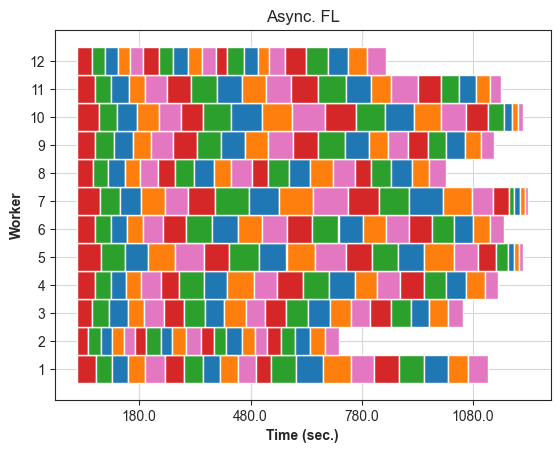

In [17]:
plot_execution_schedule(async_df, relative_time=True, rel_time_format="%d %H:%M")
ticks = list(range(1, 13))
plt.yticks(ticks, ticks)
plt.xlabel("Time (sec.)", weight="bold")
plt.ylabel("Worker", weight="bold")
plt.title("Async. FL")
plt.savefig("async_demo.pdf")
plt.show()

|   Worker ID |   Total Active Time |   Runtime |   % Idle |
|-------------+---------------------+-----------+----------|
|           1 |             1238.48 |   1340.91 |  7.63889 |
|           2 |              700.1  |   1314.43 | 46.7374  |
|           3 |             1096.4  |   1336.35 | 17.9554  |
|           4 |             1194.42 |   1338.95 | 10.7939  |
|           5 |             1260.92 |   1342.16 |  6.053   |
|           6 |             1242.47 |   1340.56 |  7.31763 |
|           7 |             1284    |   1343.19 |  4.40638 |
|           8 |             1013.61 |   1327.04 | 23.6189  |
|           9 |             1151.22 |   1337.1  | 13.9019  |
|          10 |             1280.26 |   1342.42 |  4.63037 |
|          11 |             1101.54 |   1332.95 | 17.3608  |
|          12 |             1093.95 |   1332.22 | 17.8858  |


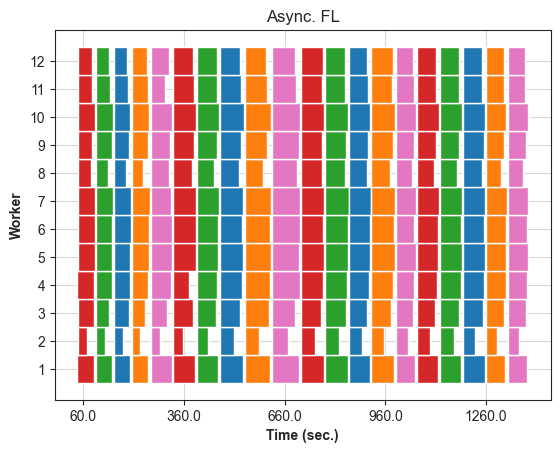

In [18]:
plot_execution_schedule(sync_df, relative_time=True, rel_time_format="%d %H:%M")
ticks = list(range(1, 13))
plt.yticks(ticks, ticks)
plt.xlabel("Time (sec.)", weight="bold")
plt.ylabel("Worker", weight="bold")
plt.title("Async. FL")
plt.savefig("sync_demo.pdf")
plt.show()

In [6]:
sync_idle = sync_df.training_end - sync_df.training_start
sync_idle.describe()

count                    188200
mean     0 days 00:00:58.407161
std      0 days 00:00:10.808184
min      0 days 00:00:24.923827
25%      0 days 00:00:51.278891
50%      0 days 00:00:59.924838
75%      0 days 00:01:05.432607
max      0 days 00:01:23.963766
dtype: object

In [7]:
async_idle = async_df.training_end - async_df.training_start
async_idle.describe()

count                    188200
mean     0 days 00:00:54.866963
std      0 days 00:00:17.181213
min      0 days 00:00:08.519517
25%      0 days 00:00:43.657528
50%      0 days 00:00:54.775647
75%      0 days 00:01:07.193204
max      0 days 00:01:34.475515
dtype: object

[WORKER=1]  total_active_time=1108.301951 / completion_time=1108.704391  =>  percent_idle=0.036298223698483234
[WORKER=2]  total_active_time=705.7964790000001 / completion_time=706.426842  =>  percent_idle=0.0892325945904382
[WORKER=3]  total_active_time=1040.3138390000001 / completion_time=1041.121546  =>  percent_idle=0.07758047108938904
[WORKER=4]  total_active_time=1134.4014769999999 / completion_time=1135.016557  =>  percent_idle=0.054191279960336125
[WORKER=5]  total_active_time=1201.8913470000002 / completion_time=1202.598116  =>  percent_idle=0.05877017355976344
[WORKER=6]  total_active_time=1149.3638160000003 / completion_time=1150.006289  =>  percent_idle=0.05586691187213777
[WORKER=7]  total_active_time=1215.3916319999998 / completion_time=1215.943563  =>  percent_idle=0.04539116919526354
[WORKER=8]  total_active_time=994.087382 / completion_time=994.788551  =>  percent_idle=0.07048422494358997
[WORKER=9]  total_active_time=1121.805252 / completion_time=1122.575175  =>  perc

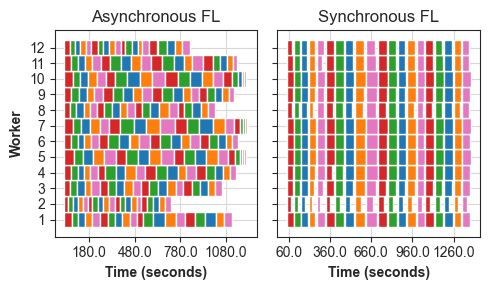

In [8]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3), sharey=True)
plot_execution_schedule(async_df, relative_time=True, ax=axes[0], rel_time_format="%d %H:%M")
plot_execution_schedule(sync_df, relative_time=True, ax=axes[1], rel_time_format="%d %H:%M")

# axes[0].tick_params(axis="x", labelrotation=45)
# axes[1].tick_params(axis="x", labelrotation=45)

ticks = list(range(1, 13))
axes[0].set_yticks(ticks, ticks)
axes[1].set_yticks(ticks, ticks)

axes[0].set_ylabel("Worker", weight="bold")
axes[0].set_xlabel("Time", weight="bold")
axes[1].set_xlabel("Time", weight="bold")

axes[0].set_xlabel("Time (seconds)", weight="bold")
axes[1].set_xlabel("Time (seconds)", weight="bold")

axes[0].set_title("Asynchronous FL", weight="normal")
axes[1].set_title("Synchronous FL", weight="normal")

# Fix the first xtick to 0.
for i in [0, 1]:
    continue
    xticks = axes[i].get_xticks()
    xtick_labels = axes[i].get_xticklabels()
    tick0, tick1 = xticks[0], xticks[1]

    if i == 0:
        xticks = xticks[1:]
        xtick_labels = xtick_labels[1:]

    axes[i].set_xticks(xticks, xtick_labels, rotation=45)

# for i, vline in enumerate([19812.71966, 19812.7198, 19812.71993, 19812.72005, 19812.72018]):
#     if i == 4:
#         axes[1].axvline(vline, color="blue", linestyle="--", label="Aggregation")
#     else:
#         axes[1].axvline(vline, color="blue", linestyle="--")
# plt.legend(bbox_to_anchor=(0.75, 1.25), loc="upper center", frameon=False)

plt.tight_layout()
plt.savefig("sync_vs_async.pdf", bbox_inches="tight")
plt.show()

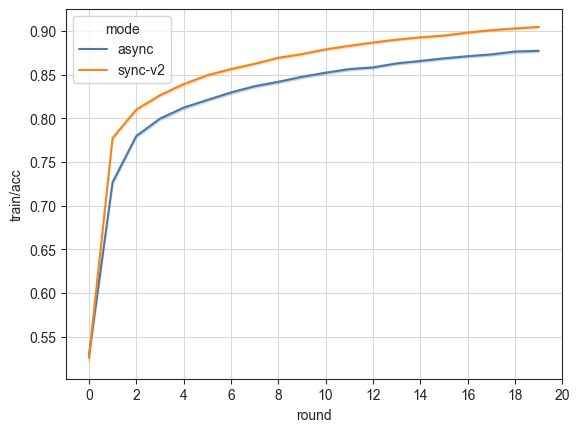

In [9]:
tmp = pd.concat([async_df, sync_df])
sns.lineplot(
    tmp,
    x="round",
    # x="train/rel_time",
    y="train/acc",
    hue="mode",
)
ticks = list(range(0, 20 + 1, 2))
plt.xticks(ticks, ticks)
plt.show()